In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

In [2]:
gpus = tf.config.list_physical_devices(device_type = 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
class DataLoader:
    def __init__(self):
        AS_dataset = pd.read_csv('./Arbitrary_Single_band_Coupler_Phase_Shift.csv', encoding='utf-8')
        self.X = AS_dataset.loc[:,'freq':'L4'].to_numpy(dtype=np.float32)
        self.y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy(dtype=np.float32)
#         self.mmX = MinMaxScaler()
#         self.X[:,1:] = self.mmX.fit_transform(self.X[:,1:])
        self.X[:,0] = self.X[:,0] * 10
        self.X_train, self.X_vali, self.y_train, self.y_vali = train_test_split(self.X, self.y, test_size=0.1, random_state=0)
        self.num_train = self.X_train.shape[0]
    def get_batch(self, batch_size=0, mode='train'):
        if mode == 'train':
            index = np.random.randint(0, self.num_train, batch_size)
            return self.X_train[index], self.y_train[index]
        if mode == 'validate':
            return self.X_vali, self.y_vali

In [4]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(100, 128)
        self.dense0 = tf.keras.layers.Dense(units=12, activation=tf.nn.leaky_relu)
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense4 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense5 = tf.keras.layers.Dense(units=8)
    
#     @tf.function
    def call(self, inputs, freq):
        f_emb = self.emb(freq)
        x = self.dense1(inputs + tf.squeeze(self.dense0(f_emb)))
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.dense5(x)
        return output

In [5]:
num_epochs = 200
batch_size = 128
learning_rate = 0.001

In [6]:
model = MLP()
data_loader = DataLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
X_v, y_v = data_loader.get_batch(mode='validate')

epoch:0
train mse:0.06790299713611603 rmse:0.2605820298194885 mae:0.20670920610427856 r2:0.4366116523742676 EC:0.3853749632835388
vali mse:0.06235039606690407 rmse:0.2497006058692932 mae:0.20120209455490112 r2:0.48391228914260864
epoch:10
train mse:0.016629565507173538 rmse:0.1289556622505188 mae:0.09768742322921753 r2:0.86273193359375 EC:0.8974366188049316
vali mse:0.020203467458486557 rmse:0.14213889837265015 mae:0.10836994647979736 r2:0.8327715396881104
epoch:20
train mse:0.012368805706501007 rmse:0.11121512949466705 mae:0.0850924402475357 r2:0.8970972299575806 EC:0.9111815690994263
vali mse:0.012840782292187214 rmse:0.11331717669963837 mae:0.08602221310138702 r2:0.8937140703201294
epoch:30
train mse:0.009132864885032177 rmse:0.095566026866436 mae:0.07040613144636154 r2:0.9241982698440552 EC:0.9095768928527832
vali mse:0.009539948776364326 rmse:0.09767265617847443 mae:0.07372818142175674 r2:0.9210357666015625
epoch:40
train mse:0.007871679030358791 rmse:0.08872248232364655 mae:0.067

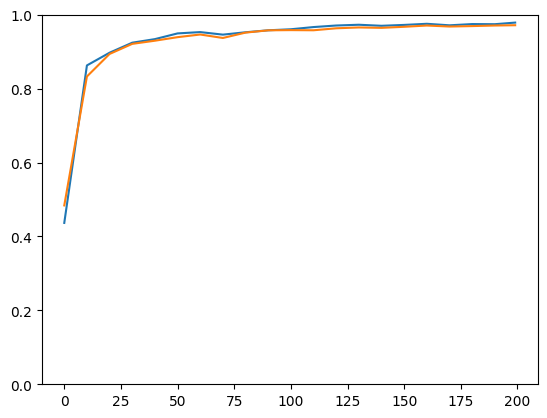

In [7]:
showX = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199]
showY1 = []
showY2 = []

num_batch = data_loader.num_train // batch_size
for epoch_index in range(num_epochs):
    for batch in range(num_batch):
        X, y = data_loader.get_batch(batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X[:,1:], X[:,:1])
            tr_mse = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(tr_mse, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    if epoch_index % 10 == 0 or epoch_index == num_epochs - 1:
        tr_EC = tf.reduce_mean(tf.reduce_sum(tf.square(y_pred), axis=1))
        tr_rmse = tf.sqrt(tr_mse)
        tr_mae = tf.reduce_mean(tf.abs(y_pred - y))
        tr_r2 = 1 - tf.reduce_sum(tf.square(y_pred - y)) / tf.reduce_sum(tf.square(y - tf.reduce_mean(y)))
        print("epoch:{}".format(epoch_index))
        print("train mse:{} rmse:{} mae:{} r2:{} EC:{}".format(tr_mse, tr_rmse, tr_mae, tr_r2, tr_EC))
        y_v_p = model(X_v[:,1:], X_v[:,:1])
        va_mse = tf.reduce_mean(tf.square(y_v_p - y_v))
        va_rmse = tf.sqrt(va_mse)
        va_mae = tf.reduce_mean(tf.abs(y_v_p - y_v))
        va_r2 = 1 - tf.reduce_sum(tf.square(y_v_p - y_v)) / tf.reduce_sum(tf.square(y_v - tf.reduce_mean(y_v)))
        print("vali mse:{} rmse:{} mae:{} r2:{}".format(va_mse, va_rmse, va_mae, va_r2))
        showY1.append(tr_r2)
        showY2.append(va_r2)
plt.plot(showX, showY1)
plt.plot(showX, showY2)
plt.ylim(0, 1)
plt.show()

In [17]:
tf.saved_model.save(model, './models')

INFO:tensorflow:Assets written to: ./models/assets


In [20]:
model = tf.saved_model.load('./models')

In [8]:
def dgn_obj(s_para, dis = False):
    E = tf.square(s_para)
    E11 = E[:,0] + E[:,1]
    E21 = E[:,2] + E[:,3]
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]
    l1 = E11 - E21 - E31 + E41
    l2 = tf.abs(E21 / (E31 + E21) - 0.71)
    # l2 = tf.abs(E21 / (E31 + E21) - 0.5)
    l3 = tf.abs(tf.math.atan2(s_para[:,3], s_para[:,2]) - tf.math.atan2(s_para[:,5], s_para[:,4]) - np.pi / 4)
    # l3 = tf.abs(tf.math.atan2(s_para[:,5], s_para[:,4]) - tf.math.atan2(s_para[:,3], s_para[:,2]) - 0.14 * np.pi)
    l4 = tf.abs(tf.reduce_sum(E, axis=1) - 1)
    loss = l1 + l2 + l3 + l4
    if dis == True:
        print("l1", l1.numpy()[0])
        print("l2", l2.numpy()[0])
        print("l3", l3.numpy()[0])
        print("l4", l4.numpy()[0])
    return loss
def loss_func(s1, s2, s3, dis = False):
    # 21和31的方差
    var = tf.reduce_sum(tf.nn.moments(tf.stack([s1, s2, s3], axis=1), [1])[1][:, 2: 6], axis=-1)
    if dis == True:
        print("var", var.numpy()[0])
    return var + dgn_obj(s1, dis) + dgn_obj(s2, dis) + dgn_obj(s3, dis)

In [9]:
num_nodes = 5000
num_node_epochs = 1000

In [14]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

mmin = np.min(data_loader.X[: , 1: ], axis=0)
mmax = np.max(data_loader.X[: , 1: ], axis=0)

structure = tf.Variable(np.random.uniform(mmin, mmax, (num_nodes, 12)), dtype=tf.float32)

freq1 = tf.ones([num_nodes, 1]) * 24
freq2 = tf.ones([num_nodes, 1]) * 25
freq3 = tf.ones([num_nodes, 1]) * 26

In [15]:
bestLoss = 10
bestStructure = 0

In [16]:
def check(structure):
    # inva_place1 = tf.where(structure[:,:8] < 1)
    inva_place1 = tf.where(tf.logical_or(structure[:,:8] < 1, structure[:,:8] > 4))
    structure = tf.tensor_scatter_nd_update(structure, [inva_place1], [np.random.uniform(mmin[inva_place1[:,1]], mmax[inva_place1[:,1]], (inva_place1.shape[0]))])
    
    # inva_place2 = tf.where(structure[:,8:] < 4) + [0, 8]
    inva_place2 = tf.where(tf.logical_or(structure[:,8:] < 4, structure[:,8:] > 100)) + [0, 8]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place2], [np.random.uniform(mmin[inva_place2[:,1]], mmax[inva_place2[:,1]], (inva_place2.shape[0]))])
    
    return tf.Variable(structure)
    
    # structure[j] = tf.Variable(tf.tensor_scatter_nd_update(structure[j], [nega_place], [np.random.uniform(0, 1, (nega_place.shape[0]))]))

In [17]:
for i in range(num_node_epochs):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(structure)
        y_pred1 = model(structure, freq1)
        y_pred2 = model(structure, freq2)
        y_pred3 = model(structure, freq3)
        loss = loss_func(y_pred1, y_pred2, y_pred3)
    minLoss = tf.reduce_min(loss).numpy()
    minIndex = tf.argmin(loss).numpy()
    minS = structure[minIndex].numpy()
    grads = tape.gradient(loss, structure)
    opt.apply_gradients(grads_and_vars=zip([grads], [structure]))
    structure = check(structure)
    if minLoss < bestLoss:
        bestLoss = minLoss
        bestStructure = minS
        # bestStructure = data_loader.mmX.inverse_transform([minS[0]])[0]
        print(minIndex)
        print(i, bestLoss)
        print(" ".join(map(str, bestStructure)))
        print()

4309
0 -1.4640989
4.252882 2.245256 1.467756 2.2901738 4.0445223 2.7146487 4.444996 2.699194 17.52093 36.214405 14.430434 7.7816925

4309
1 -1.6318734
2.3377173 2.2352562 1.4777563 2.3001738 1.2830361 2.7046487 2.8196783 2.6891937 17.510931 36.204407 14.420434 7.791692

4309
2 -1.6511068
2.345158 2.2426975 1.4703149 2.307615 1.2904775 2.697208 2.8122375 2.6966348 17.518372 36.196964 14.4278755 7.7991304

4309
3 -1.6673993
2.3515456 2.2490857 1.4639267 2.314003 1.2968656 2.6908202 2.80585 2.7030225 17.52476 36.190575 14.434263 7.8055162

4309
4 -1.6823399
2.3573563 2.2548969 1.4581153 2.3198142 1.3026768 2.6850095 2.800039 2.7088335 17.53057 36.184765 14.440074 7.8113246

4309
5 -1.6964967
2.3628106 2.2603517 1.4526604 2.325269 1.3081317 2.679555 2.7945845 2.714288 17.536024 36.17931 14.445529 7.8167763

4309
6 -1.7098389
2.3680313 2.2655728 1.4474393 2.33049 1.3133528 2.674334 2.7893636 2.719509 17.541245 36.174088 14.45075 7.821995

4309
7 -1.7219733
2.3730946 2.2706366 1.4423755 2.33

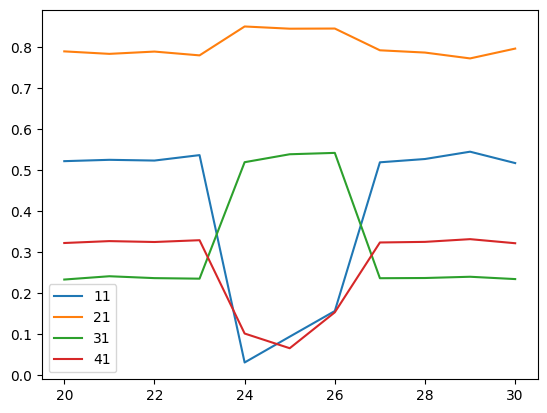

In [18]:
# 画图
fig_freq = tf.linspace(20, 30, 11)
# fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([bestStructure], [21, 1])], axis=-1)
fig_y = model(tf.tile([bestStructure], [11, 1]), tf.reshape(fig_freq, (-1, 1)))
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()

In [15]:
# S4P
l = fig_y.numpy().tolist()
for i in range(len(l)):
    print(round(fig_freq.numpy()[i]*1000,0), end="\t")
    print(l[i][0], l[i][1], "0\t" * 6, sep="\t")
    print(l[i][2], l[i][3], "0\t" * 6, sep="\t")
    print(l[i][4], l[i][5], "0\t" * 6, sep="\t")
    print(l[i][6], l[i][7], "0\t" * 6, sep="\t")

2000.0	-0.19793671369552612	0.2842220067977905	0	0	0	0	0	0	
0.14781898260116577	0.6541474461555481	0	0	0	0	0	0	
0.3382514715194702	0.32167527079582214	0	0	0	0	0	0	
-0.14639127254486084	-0.13702771067619324	0	0	0	0	0	0	
2050.0	-0.15777933597564697	0.2936699688434601	0	0	0	0	0	0	
0.20072618126869202	0.6307808756828308	0	0	0	0	0	0	
0.37714147567749023	0.29594799876213074	0	0	0	0	0	0	
-0.16160833835601807	-0.11072352528572083	0	0	0	0	0	0	
2100.0	-0.12066918611526489	0.29319506883621216	0	0	0	0	0	0	
0.27206867933273315	0.5963115096092224	0	0	0	0	0	0	
0.4101918041706085	0.2606014311313629	0	0	0	0	0	0	
-0.16136276721954346	-0.08319705724716187	0	0	0	0	0	0	
2150.0	-0.08213382959365845	0.2591746747493744	0	0	0	0	0	0	
0.3511660695075989	0.5520557165145874	0	0	0	0	0	0	
0.46001243591308594	0.20252999663352966	0	0	0	0	0	0	
-0.15228253602981567	-0.061626311391592026	0	0	0	0	0	0	
2200.0	-0.0405118465423584	0.2140592336654663	0	0	0	0	0	0	
0.44056397676467896	0.49224841594696045	0	0	0	0	0	0	
0.50233763

In [17]:
GT_struct = tf.constant([2.27248, 2.52657, 1.06926, 3.83355, 1.92307, 1.74249, 1.37051,  1.52846,  17.2486, 66.9054, 18.5276, 50.3882])
# GT_struct = tf.constant([2.28537, 3.26143, 1.77117, 3.44183, 1.36415, 1.79982, 3.4657, 1.00883, 17.4404, 67.2932, 14.5402, 47.8842])
MP_X = tf.concat([tf.constant([[2.4],[2.5],[2.6]]), tf.tile([bestStructure], [3, 1])], axis=-1)
GT_X = tf.concat([tf.constant([[2.4],[2.5],[2.6]]), tf.tile([GT_struct], [3, 1])], axis=-1)
MP_y = model(MP_X)
GT_y = model(GT_X)
print("MP")
MP_loss = loss_func(MP_y[0:1], MP_y[1:2], MP_y[2:3], dis=True)
print(MP_loss)
print("GT")
GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], dis=True)
print(GT_loss)

MP
var 0.050856646
l1 -0.9721394
l2 0.033097327
l3 0.0203318
l4 0.0035675764
l1 -0.99062276
l2 0.03210914
l3 0.006899476
l4 0.0103446245
l1 -0.86170745
l2 0.021279097
l3 0.007969439
l4 0.00061810017
tf.Tensor([-2.6373963], shape=(1,), dtype=float32)
GT
var 0.059403744
l1 -0.81727177
l2 0.066189826
l3 0.06538272
l4 0.10180467
l1 -0.9890073
l2 0.043469846
l3 0.011388361
l4 0.003681302
l1 -0.8551806
l2 0.00059854984
l3 0.089188576
l4 0.057194114
tf.Tensor([-2.163158], shape=(1,), dtype=float32)


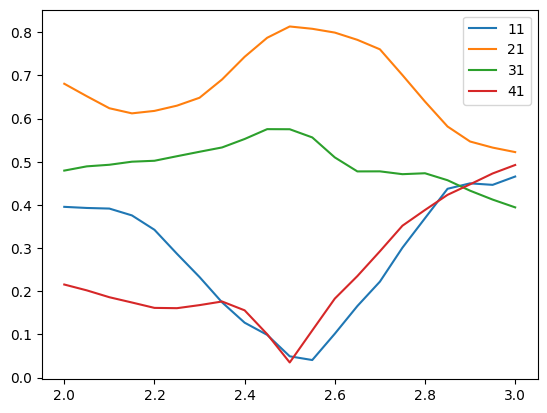

In [18]:
# 画图
fig_freq = tf.linspace(2.0, 3.0, 21)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([GT_struct], [21, 1])], axis=-1)
fig_y = model(fig_x)
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()